# LECTURE 6 — SCG og mekaniske hændelser
## Filtrering + feature timing (SciPy)

**Applied Programming (BME, 2. semester)**  
**Varighed:** 2 timer forelæsning (slides) + ca. 2 timer øvelser  



## Læringsmål

Efter i dag kan du:

- forklare hvorfor *scipy.signal* er nyttigt til filtrering (ud over NumPy)
- beskrive og bruge **glidende gennemsnit** og **Savitzky–Golay** smoothing
- forklare hvad et **histogram** viser, og hvorfor det er stærkt (relateret til middelværdi og standardafvigelse)
- udføre en simpel feature‑workflow på SCG: filtrering → peak detection → timing‑intervaller
- diskutere *data provenance* og hvorfor metadata (sampling rate, enhed, kalibrering) er kritisk


## Dagens plan

- SciPy til signaler: smoothing og hvorfor valg af parametre betyder noget
- Visualiseringer vi bruger (og hvad de kan fortælle)
- Kort intro til SCG og mekaniske events (IC, AO, AC)
- Feature extraction workflow og *find_peaks*
- Mini‑etik: metadata og provenance
- Øvelsessession


## Setup (kør først)

Vi bruger:

- `numpy` til arrays og basal statistik
- `matplotlib` til plots
- `scipy.signal` til smoothing og peak detection


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(7)


## Visualisering: Tidsserieplot

**Hvad:** Signalværdi over tid (x-akse = tid, y-akse = amplitude)  
**Stærkt når:** du vil se form, støj, trends, artefakter og placere events i tid.

**Typisk i dagens notebook:**

- rå SCG (noisy)
- filtreret/smoothed SCG
- markering af peaks (AO‑kandidater)


## Visualisering: Overlay‑plot (før/efter)

**Hvad:** flere tidsserier i samme figur (fx rå vs. filtreret)  
**Stærkt når:** du vil sammenligne effekten af et filter og checke om peaks forskydes eller flades ud.

**Advarsel:** smoothing kan ændre peak‑højde og (nogle gange) peak‑timing.


## Visualisering: Histogram

**Hvad:** Et histogram grupperer data i intervaller (*bins*) og tæller hvor mange observationer der ligger i hvert interval. citeturn1search9  

**Hvorfor er det stærkt?**

- giver et hurtigt billede af **fordelingen**: centrum, spredning, skævhed, outliers citeturn1search9
- hjælper dig med at forstå **middelværdi** (hvor data typisk ligger) og **standardafvigelse** (hvor bredt det ligger) i praksis

**I dag bruger vi histogram til:**

- at beskrive støj (før/efter filtrering)
- at kigge på beat‑to‑beat intervaller (AO–AO) og timing (R→AO)


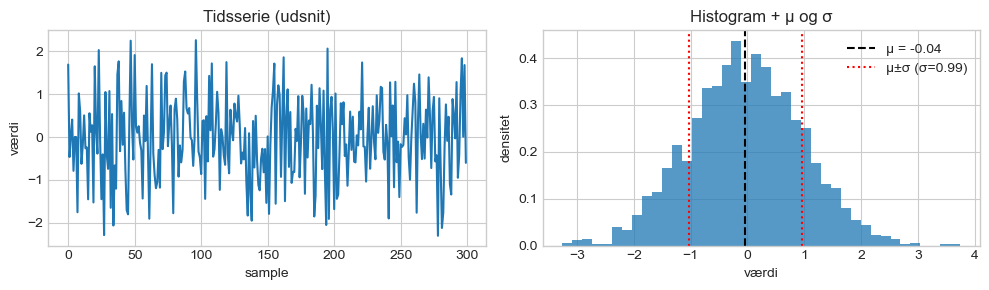

In [2]:
# Mini-demo: histogram + middelværdi + std
x = np.random.normal(loc=0.0, scale=1.0, size=2000)
mu = x.mean()
sigma = x.std(ddof=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(x[:300])
ax[0].set_title('Tidsserie (udsnit)')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('værdi')

ax[1].hist(x, bins=40, density=True, alpha=0.75)
ax[1].axvline(mu, color='k', linestyle='--', label=f'μ = {mu:.2f}')
ax[1].axvline(mu+sigma, color='r', linestyle=':', label=f'μ±σ (σ={sigma:.2f})')
ax[1].axvline(mu-sigma, color='r', linestyle=':')
ax[1].set_title('Histogram + μ og σ')
ax[1].set_xlabel('værdi')
ax[1].set_ylabel('densitet')
ax[1].legend()
plt.tight_layout()
plt.show()


## Konceptspørgsmål: Histogram og σ

Du ser et histogram (som i demoen).  

**Spørgsmål:** Hvis vi øger støjniveauet i signalet (større varians), hvad forventer du sker med:

- histogrammets form?
- middelværdi (μ)?
- standardafvigelse (σ)?

Skriv 2–3 sætninger.


## Svar: Histogram og σ

- Når støjen øges, bliver fordelingen **bredere** → histogrammet “spredes ud”. citeturn1search9  
- Middelværdien μ ændrer sig typisk **ikke systematisk** (hvis støjen er omkring 0 og uden bias).  
- Standardafvigelsen σ bliver **større**, fordi data varierer mere omkring μ.

👉 Praktisk pointe: Histogrammet er et visuelt supplement til μ og σ — du ser straks om fordelingen fx er skæv eller har outliers, som μ/σ alene kan skjule.


## Hvorfor SciPy (ikke kun NumPy)?

NumPy er fantastisk til arrays og simple beregninger — men signalbehandling har mange “færdige byggeklodser”:

- smoothing/filtrering (Savitzky–Golay, Butterworth, FIR)
- peak detection med egenskaber (prominence, width, distance)
- konvolvering og spektralanalyse (PSD, STFT)

I dag: vi bruger `scipy.signal.savgol_filter` og `scipy.signal.find_peaks`. citeturn1search18turn1search24


## Smoothing: glidende gennemsnit (moving average)

**Idé:** erstat hvert punkt med gennemsnittet af en lokal vindue‑nabolag.

- simpelt og hurtigt
- virker som et lavpasfilter (fjerner højfrekvent støj)

**Ulempe:** kan “runde” skarpe peaks og reducere amplitude → kan gøre timing sværere.


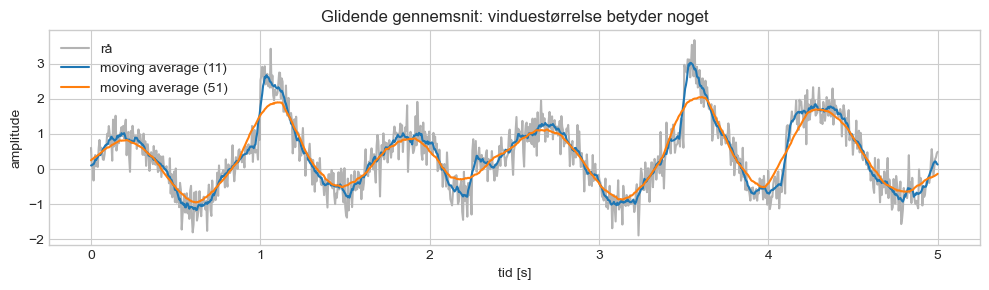

In [5]:
def moving_average(x, window):
    window = int(window)
    if window < 1:
        raise ValueError('window skal være >= 1')
    # 'same' for at få samme længde som input
    kernel = np.ones(window) / window
    return np.convolve(x, kernel, mode='same')

# Syntetisk signal: sinus + støj + enkelte 'events'
t = np.linspace(0, 5, 1000)
clean = np.sin(2*np.pi*1.2*t)
events = np.zeros_like(t)
events[[200, 450, 700, 820]] = [2.0, 1.5, 2.2, 1.8]
noisy = clean + 0.35*np.random.randn(len(t)) + signal.lfilter([1], [1, -0.98], events)  # lidt 'ringing'

ma_11 = moving_average(noisy, 11)
ma_51 = moving_average(noisy, 51)

plt.figure(figsize=(10,3))
plt.plot(t, noisy, color='0.7', label='rå')
plt.plot(t, ma_11, label='moving average (11)')
plt.plot(t, ma_51, label='moving average (51)')
plt.title('Glidende gennemsnit: vinduestørrelse betyder noget')
plt.xlabel('tid [s]')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()


## Smoothing: Savitzky–Golay

**Idé:** fit et lav‑gradspolynomium lokalt i et vindue og evaluer i midten.

- bevarer ofte **peak‑form** bedre end moving average
- kræver valg af `window_length` og `polyorder`

I SciPy: `scipy.signal.savgol_filter(x, window_length, polyorder, ...)` citeturn1search18turn1search23


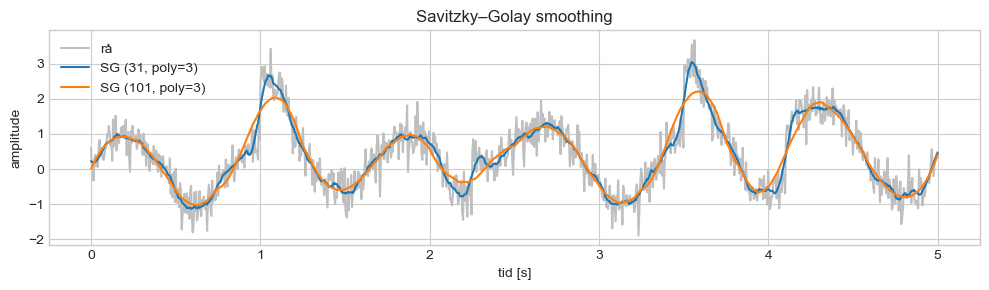

In [6]:
sg_31_3 = signal.savgol_filter(noisy, window_length=31, polyorder=3)
sg_101_3 = signal.savgol_filter(noisy, window_length=101, polyorder=3)

plt.figure(figsize=(10,3))
plt.plot(t, noisy, color='0.75', label='rå')
plt.plot(t, sg_31_3, label='SG (31, poly=3)')
plt.plot(t, sg_101_3, label='SG (101, poly=3)')
plt.title('Savitzky–Golay smoothing')
plt.xlabel('tid [s]')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()


## Mini‑øvelse (koncept + kode): Smoothing på syntetisk data

**Spørgsmål:** Hvilken af de to smoothing‑metoder (moving average vs Savitzky–Golay) bevarer bedst de skarpe events i signalet?

- Kig på figuren
- Brug også et histogram af residualen: `residual = rå - smoothed`

Skriv en kort begrundelse.


## Svar: Smoothing på syntetisk data

Der er ikke ét “altid rigtigt” svar, men typisk:

- **Savitzky–Golay** bevarer peak‑form bedre, fordi den lokalt approksimerer med polynomium i stedet for ren averaging. citeturn1search18turn1search23  
- **Moving average** kan flade peaks ud, især ved store vinduer.

Residual‑histogrammet hjælper: en god smoothing reducerer residual‑spredningen (lavere σ) uden at fjerne “struktur” (systematiske fejl).


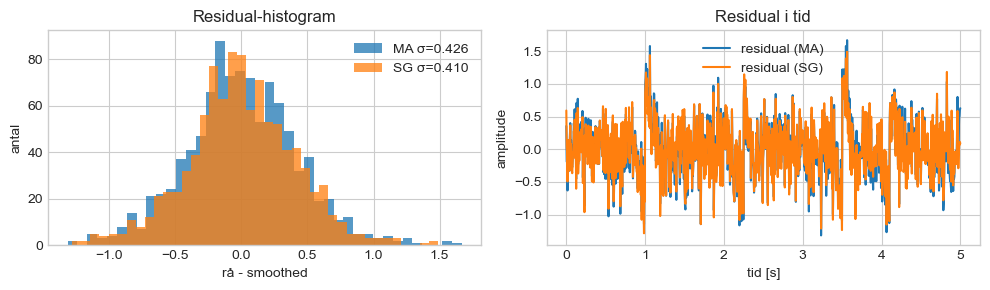

In [7]:
res_ma = noisy - ma_51
res_sg = noisy - sg_101_3

fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].hist(res_ma, bins=40, alpha=0.75, label=f'MA σ={res_ma.std(ddof=1):.3f}')
ax[0].hist(res_sg, bins=40, alpha=0.75, label=f'SG σ={res_sg.std(ddof=1):.3f}')
ax[0].set_title('Residual-histogram')
ax[0].set_xlabel('rå - smoothed')
ax[0].set_ylabel('antal')
ax[0].legend()

ax[1].plot(t, res_ma, label='residual (MA)')
ax[1].plot(t, res_sg, label='residual (SG)')
ax[1].set_title('Residual i tid')
ax[1].set_xlabel('tid [s]')
ax[1].set_ylabel('amplitude')
ax[1].legend()

plt.tight_layout()
plt.show()


## Introduktion til SCG

**Seismocardiografi (SCG)** måler mikrovibrationer på brystkassen fra hjertets mekaniske aktivitet (typisk med accelerometer). citeturn1search42turn1search31  

SCG er *mekanisk*, mens ECG er *elektrisk*:

- ECG: depolarisering/aktivitet i hjertets ledningssystem
- SCG: mekaniske events (ventil‑åbning/lukning, blodacceleration, vægbevægelse)

➡️ Derfor kommer SCG‑peaks ofte **forsinket** i forhold til ECG‑R‑peak (elektromekanisk forsinkelse).


## Mekaniske hændelser (fiducial points)

I litteraturen bruges flere labels. I denne lektion fokuserer vi på:

- **IC**: isovolumetrisk kontraktion / tidlige systoliske mekaniske bevægelser
- **AO**: *aortic valve opening* (aortaklap åbner)
- **AC**: *aortic valve closure* (aortaklap lukker)

Disse fiducial points kan korreleres med fysiologiske events målt med fx ultralyd. citeturn1search31turn1search32


## SCG vs ECG peaks

- ECG R‑peak er et **elektrisk** referencepunkt.
- AO/AC i SCG relaterer til **klap‑events** og blodets acceleration.

Konsekvens:

- du kan ikke “genbruge” ECG‑peak‑logik direkte på SCG
- du skal ofte filtrere og vælge robuste peak‑kriterier (prominence, distance)


## Konceptspørgsmål: Hvor er AO?

Du får vist en smoothed SCG‑kurve for ét beat.

**Spørgsmål:** Hvilken peak ville du vælge som en *AO‑kandidat* — og hvorfor?

Tænk på:

- amplitude (højde)
- form (spids vs bred)
- stabilitet på tværs af beats


## Svar: Hvor er AO?

I praksis vælger man ofte en peak der:

- er **konsistent** i et forventet tidsvindue efter R‑peak (hvis ECG findes)
- har høj **prominence** (står tydeligt ud fra omgivelserne) citeturn1search24
- ikke bryder fysiologiske constraints (fx minimum afstand mellem beats)

👉 Dagens workflow bruger `find_peaks` + et tidsvindue for at få robuste AO‑kandidater.


## Peak detection med `scipy.signal.find_peaks`

`find_peaks` finder lokale maxima og kan filtrere dem med egenskaber: citeturn1search24

- `height`: minimum peak‑højde
- `distance`: minimum afstand mellem peaks (i samples)
- `prominence`: hvor meget peak står ud fra “terrænet”
- `width`: minimum bredde

➡️ For biomekaniske signaler er `prominence` ofte mere robust end ren `height` når baseline driver.


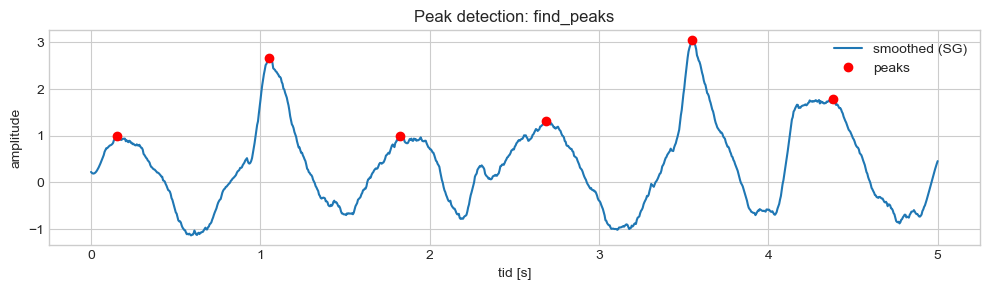

Antal peaks: 6
Eksempel på prominences: [0.8138745  3.68314539 1.68580179 2.09671098 3.92460702]


In [8]:
# Mini-demo: find_peaks på vores syntetiske signal
peaks, props = signal.find_peaks(sg_31_3, prominence=0.6, distance=80)

plt.figure(figsize=(10,3))
plt.plot(t, sg_31_3, label='smoothed (SG)')
plt.plot(t[peaks], sg_31_3[peaks], 'ro', label='peaks')
plt.title('Peak detection: find_peaks')
plt.xlabel('tid [s]')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

print('Antal peaks:', len(peaks))
print('Eksempel på prominences:', props['prominences'][:5])


## Workflow: fra rå SCG til timing‑intervaller

En simpel pipeline:

- indlæs signal + metadata (fs, enhed)
- filtrer/smooth (fx SG)
- find peaks (AO‑kandidater)
- segmentér beats
- udregn intervaller (AO–AO, evt. R→AO)
- visualisér og sanity‑check med plots + histogram


## Real data (når muligt)

I øvelserne bruger vi rigtige SCG‑data som CSV.

Mulige kilder (eksempler):

- **MSCardio** (smartphone‑SCG, CSV + metadata, MIT‑licens). citeturn1search13  
- **PhysioNet SCG‑RHC** (wearable SCG + kliniske målinger). citeturn1search1

I denne notebook kan du enten:

- læse en lokal `scg.csv` (anbefalet i undervisningen)
- eller bruge en lille fallback‑demo (syntetisk) hvis filen ikke findes


## Indlæsning: forventet filformat

Vi antager en CSV med kolonner som minimum:

- `t` (sekunder) eller en sample‑indeks kolonne
- `scg` (en akse, fx z)

Hvis der findes ECG i samme fil, forventer vi også:

- `ecg`

Hvis din fil hedder noget andet, tilpas variablerne i koden.


In [9]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path('data')
SCG_FILE = DATA_PATH / 'scg_ecg_example.csv'   # underviser kan lægge filen her

if SCG_FILE.exists():
    df = pd.read_csv(SCG_FILE)
    print('Loaded:', SCG_FILE)
else:
    print('Fandt ikke', SCG_FILE, '→ bruger fallback (syntetisk demo)')
    fs = 200  # Hz
    t = np.arange(0, 20, 1/fs)
    # "SCG-lignende" bølge: sum af band-limited bursts + støj
    base = 0.15*np.sin(2*np.pi*1.1*t) + 0.05*np.sin(2*np.pi*3.2*t)
    beat_times = np.arange(0.8, t[-1], 0.9)
    scg = base.copy()
    for bt in beat_times:
        scg += 0.9*np.exp(-0.5*((t-(bt+0.12))/0.03)**2)   # AO-lignende peak
        scg += -0.5*np.exp(-0.5*((t-(bt+0.35))/0.04)**2)  # AC-lignende trough
    scg += 0.15*np.random.randn(len(t))

    # "ECG-lignende" R-peaks
    ecg = 0.03*np.random.randn(len(t))
    for bt in beat_times:
        ecg += 1.2*np.exp(-0.5*((t-bt)/0.01)**2)

    df = pd.DataFrame({'t': t, 'scg': scg, 'ecg': ecg})

# inferér fs hvis muligt
if 't' in df.columns:
    fs = 1/np.median(np.diff(df['t'].values))
else:
    fs = 200
    df['t'] = np.arange(len(df))/fs

print(f"fs ≈ {fs:.1f} Hz, N={len(df)}")
df.head()


Fandt ikke data\scg_ecg_example.csv → bruger fallback (syntetisk demo)
fs ≈ 200.0 Hz, N=4000


,t,scg,ecg
0,0.000,0.062377,0.000100
1,0.005,-0.029549,-0.032529
2,0.010,-0.207281,-0.017447
3,0.015,0.191880,0.007392
4,0.020,0.133774,0.032269


## Visualisering: rå data (SCG + evt. ECG)

Før du filtrerer: plot altid et kort udsnit.

- ser du baseline‑drift?
- ser du saturering/clipping?
- er sampling rate plausibel?


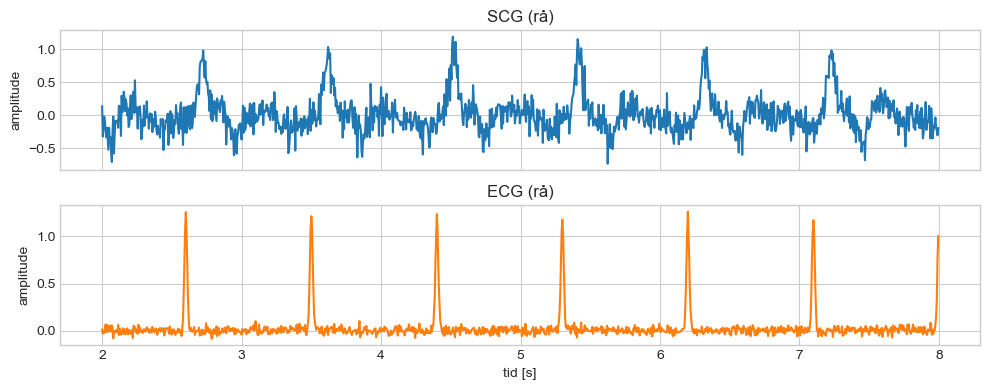

In [10]:
start_s = 2
win_s = 6
mask = (df['t'] >= start_s) & (df['t'] < start_s + win_s)

fig, ax = plt.subplots(2, 1, figsize=(10,4), sharex=True)
ax[0].plot(df.loc[mask, 't'], df.loc[mask, 'scg'])
ax[0].set_title('SCG (rå)')
ax[0].set_ylabel('amplitude')

if 'ecg' in df.columns:
    ax[1].plot(df.loc[mask, 't'], df.loc[mask, 'ecg'], color='tab:orange')
    ax[1].set_title('ECG (rå)')
    ax[1].set_ylabel('amplitude')
else:
    ax[1].axis('off')

ax[-1].set_xlabel('tid [s]')
plt.tight_layout()
plt.show()


## Filtrering/smoothing på real data

Vi starter med smoothing (ikke fuld bandpass) for at holde det enkelt.

To valg:

- moving average (hurtigt, men kan sløre peaks)
- Savitzky–Golay (ofte bedre på peaks) citeturn1search18turn1search23

I øvelserne sammenligner du dem på SCG.


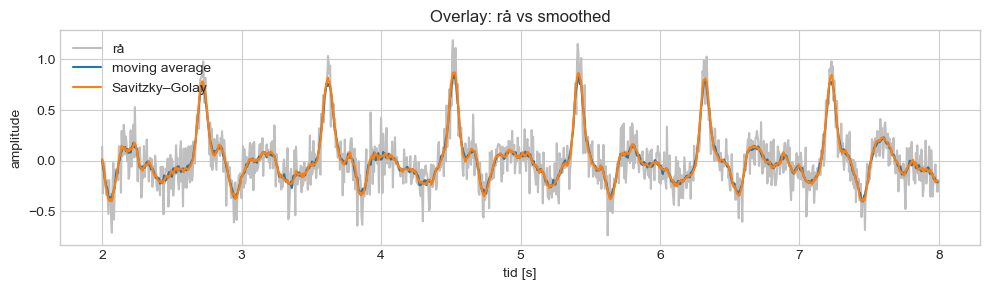

In [11]:
scg = df['scg'].values

scg_ma = moving_average(scg, window=int(0.05*fs) // 2 * 2 + 1)  # ~50 ms, sørg for ulige
scg_sg = signal.savgol_filter(scg, window_length=int(0.11*fs) // 2 * 2 + 1, polyorder=3)

mask = (df['t'] >= start_s) & (df['t'] < start_s + win_s)

plt.figure(figsize=(10,3))
plt.plot(df.loc[mask,'t'], df.loc[mask,'scg'], color='0.75', label='rå')
plt.plot(df.loc[mask,'t'], scg_ma[mask], label='moving average')
plt.plot(df.loc[mask,'t'], scg_sg[mask], label='Savitzky–Golay')
plt.title('Overlay: rå vs smoothed')
plt.xlabel('tid [s]')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()


## Konceptspørgsmål: Peak‑parametre

Du vil finde AO‑kandidater med `find_peaks`.

**Spørgsmål:** Hvilket parameter er mest nyttigt til at undgå at støj bliver detekteret som peaks?

- `height`
- `distance`
- `prominence`

Vælg ét og forklar kort hvorfor.


## Svar: Peak‑parametre

Ofte er **`prominence`** mest robust mod støj og baseline‑drift, fordi det måler hvor meget peaken “står ud” i forhold til omgivelserne, ikke kun dens absolutte højde. citeturn1search24

`distance` er også vigtigt, fordi fysiologi giver en minimum afstand mellem beats (ellers får du dobbelt-detektion).


## Peak detection på SCG (AO‑kandidater)

Vi starter “simpelt”:

- arbejde på den smoothed SCG
- sæt `distance` ud fra maksimal puls (fx 180 bpm)
- tune `prominence` visuelt

Bemærk: AO kan være positiv eller negativ afhængigt af akse og placering.


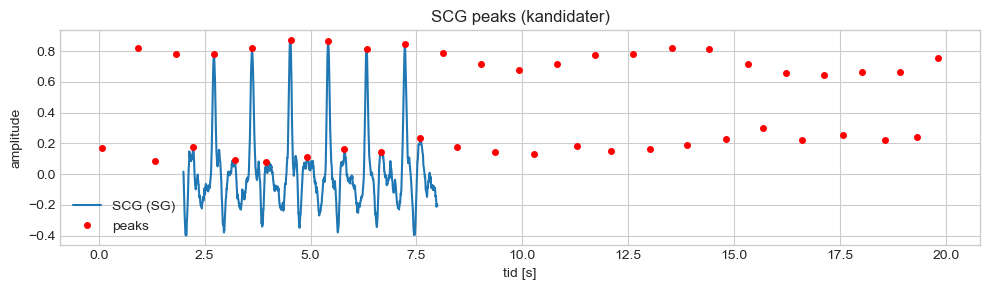

Detekterede peaks: 44


In [12]:
# Peak detection
max_hr = 180  # bpm
min_distance = int(fs * 60 / max_hr)

peaks, props = signal.find_peaks(scg_sg, distance=min_distance, prominence=np.std(scg_sg)*0.5)

# Plot udsnit med peaks
mask = (df['t'] >= start_s) & (df['t'] < start_s + win_s)

plt.figure(figsize=(10,3))
plt.plot(df.loc[mask,'t'], scg_sg[mask], label='SCG (SG)')
plt.plot(df['t'].values[peaks], scg_sg[peaks], 'ro', ms=4, label='peaks')
plt.title('SCG peaks (kandidater)')
plt.xlabel('tid [s]')
plt.ylabel('amplitude')
plt.legend()
plt.tight_layout()
plt.show()

print('Detekterede peaks:', len(peaks))


## Timing‑intervaller

To simple intervaller vi kan udlede her:

- **AO–AO**: tiden mellem successive peaks (proxy for beat interval)
- **R→AO**: hvis ECG R‑peaks findes, kan vi estimere elektromekanisk forsinkelse

Vi bruger histogram til at se fordelingen af intervaller.


AO–AO: mean=0.459s, std=0.097s (N=43)


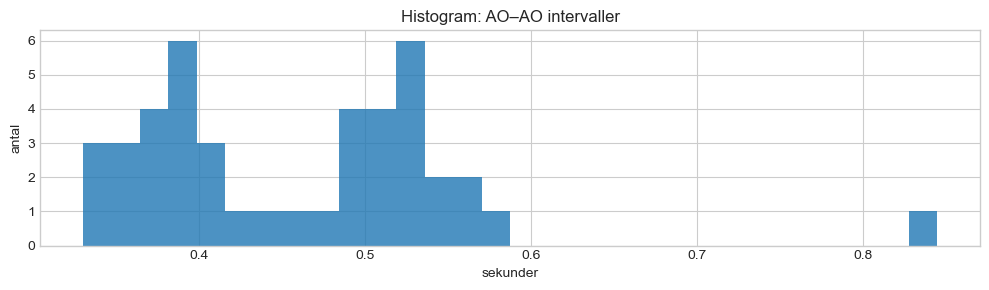

In [13]:
# AO–AO intervaller
peak_times = df['t'].values[peaks]
ao_ao = np.diff(peak_times)

print(f"AO–AO: mean={ao_ao.mean():.3f}s, std={ao_ao.std(ddof=1):.3f}s (N={len(ao_ao)})")

plt.figure(figsize=(10,3))
plt.hist(ao_ao, bins=30, alpha=0.8)
plt.title('Histogram: AO–AO intervaller')
plt.xlabel('sekunder')
plt.ylabel('antal')
plt.tight_layout()
plt.show()


## Mini‑etik: Data provenance og metadata

Når du arbejder med fysiologiske signaler, er *metadata* ikke pynt — det er nødvendigt:

- sampling rate (fs) → ellers kan du ikke oversætte samples til sekunder
- enhed og akse (m/s²? g? x/y/z?)
- device/model og firmware → kan påvirke støj og filtre
- kalibrering og drift → kan give bias over tid
- optageprotokol (stilling, respiration, aktivitet)

Datasæt som MSCardio leverer metadata pr. recording (JSON + CSV). citeturn1search13


## Sanity checks du altid bør gøre

- plot et udsnit af rå data
- plot før/efter filtrering
- markér peaks og check manuelt for falske positiver
- brug histogram på intervaller og residualer
- dokumentér dine parametre (window_length, polyorder, prominence, distance)


## 5 min: Behandling og lagring af sundhedsdata (ECG/SCG)

**Hvorfor er det en “problematik” i den her notebook?**  
Selv om vi arbejder med “bare” signaler (CSV), kan fysiologiske tidsserier + metadata ofte knyttes til en person. Derfor skal du tænke *formål, adgang, sikkerhed og sletning* som en del af dit workflow.

**1) Hvad tæller som sundhedsdata?**
- *Helbredsoplysninger* er en **særlig kategori** af personoplysninger i GDPR. ECG/SCG kan typisk være helbredsoplysninger, fordi de siger noget om fysiologisk tilstand.
- Pseudonymisering (fx “patient_001”) er **ikke anonymisering**: data kan stadig være personoplysninger, hvis genidentifikation er realistisk.

**2) Hvor går det typisk galt i projekter?**
- Data ender på private laptops/USB/Google Drive uden aftale eller kontrol
- Man gemmer “lidt ekstra” (over‑indsamling), og glemmer at slette igen
- Man deler rå data i grupper/rapport, hvor det burde være aggregeret

*Kilder:* GDPR (EU) 2016/679, bl.a. art. 9 (særlige kategorier, inkl. helbredsoplysninger) og definitionen af helbredsoplysninger; samt Databeskyttelsesloven (DK) som supplerer GDPR.  
- https://eur-lex.europa.eu/eli/reg/2016/679/oj  
- https://www.retsinformation.dk/eli/lta/2018/502

# Øvelsessession

Nedenfor er øvelserne.  

**Vigtigt:** Hver øvelse er formuleret som et problem, du skal løse — ikke en trin‑for‑trin opskrift.

Du kan arbejde i grupper.


## Øvelse: Glatning på SCG — “Hvad mister vi, hvad vinder vi?”

**Hvad handler øvelsen om (scene + mål):**  
Du har et råt SCG‑signal (og evt. metadata). Du skal lave en smoothing der reducerer støj uden at ødelægge de mekaniske events for meget.

**Det ved I/kommer I til at bruge (forventet læring):**  
I kender NumPy arrays, plot, middelværdi og std. I lærer at vælge smoothing‑parametre og argumentere med visualisering (tidsserie + histogram). I træner også at relatere histogram til μ og σ.

**Opgave (problem du skal løse):**  
Design to forskellige smoothing‑løsninger (moving average og Savitzky–Golay) til SCG‑signalet, så du kan forklare hvilken der bedst bevarer de vigtigste peaks. Underbyg din konklusion med mindst to plots og mindst én statistisk sammenligning (fx residual‑σ eller AO–AO stabilitet).

**Mini‑del: Sundhedsdata (behandling + lagring)**  
Skriv 3–5 linjer der svarer på:
- Hvilke af dine artefakter (CSV, plots, peak‑lister) er *potentielt* helbredsoplysninger/personoplysninger?
- Hvilke 2 konkrete foranstaltninger vil du bruge for sikker lagring/deling i en studie‑kontekst (fx adgangskontrol, kryptering, ingen deling af rå data, kun aggregerede figurer)?
- Hvornår kan du slette data igen (opbevaringsbegrænsning)?

*Kildeidé:* GDPR art. 5 og 32 + Databeskyttelsesloven (DK). Se links i de to slides om sundhedsdata.

### Løsningsskitse (til underviser / hvis du sidder fast)

- sammenlign rå vs MA vs SG i overlay
- beregn residualer og plot histogram
- diskuter parameter‑tradeoff


## Øvelse: Peak detection — “Find mekaniske beats”

**Hvad handler øvelsen om (scene + mål):**  
Du skal finde en serie af mekaniske beats i SCG ved at detektere en robust peak‑type (AO‑kandidater).

**Det ved I/kommer I til at bruge (forventet læring):**  
I bruger `scipy.signal.find_peaks` og jeres viden om sampling rate. I lærer at tune `distance` og `prominence`, og at evaluere resultatet med plots og intervaller.

**Opgave (problem du skal løse):**  
Find en parameter‑opsætning til `find_peaks` der giver en plausibel beat‑serie uden mange falske peaks. Udregn AO–AO intervaller og lav en figur der tydeligt viser (a) peaks på signalet og (b) et histogram af intervaller. Argumentér kort for hvorfor din løsning er “robust”.

**Mini‑del: Sundhedsdata (behandling + lagring)**  
Skriv 3–5 linjer der svarer på:
- Hvis du deler dine resultater, hvad kan du dele *uden* at dele rå sundhedsdata (fx histogrammer/summary‑stats frem for rå tidsserier)?
- Hvordan vil du undgå at en filnavngivning eller metadata “afslører” identitet (pseudonymisering og adskil nøglefil)?

*Kildeidé:* GDPR art. 5 (dataminimering/formål) + art. 32 (sikkerhed). Se links i de to slides om sundhedsdata.

### Løsningsskitse (til underviser / hvis du sidder fast)

- start med smoothed signal
- sæt `distance` ud fra max HR
- tune `prominence` ud fra signalets std
- check histogram for outliers


## Øvelse: Synkronisering ECG + SCG — “R→AO forsinkelse”

**Hvad handler øvelsen om (scene + mål):**  
Hvis du har ECG (eller R‑peaks fra tidligere), skal du estimere tidsforsinkelsen fra elektrisk aktivering (R) til mekanisk event (AO).

**Det ved I/kommer I til at bruge (forventet læring):**  
I bruger arrays, indeks→tid konvertering (fs), `find_peaks`, og basal statistik. I lærer at lave et scatterplot og en simpel regression for at se om forsinkelsen driver over tid.

**Opgave (problem du skal løse):**  
Udled en beat‑for‑beat serie af R→AO tider og visualisér den over tid (scatter/linje). Lav en lineær regression af R→AO tid mod beat‑indeks og fortolk hældningen: tyder den på ændring i mekanisk funktion eller på måle/algoritme‑drift?

**Mini‑del: Sundhedsdata (behandling + lagring)**  
Skriv 3–5 linjer der svarer på:
- Hvorfor bliver risikoen ofte *større*, når du kobler flere datakilder (ECG + SCG + metadata)?
- Hvilke ekstra sikkerheds-/adgangstiltag vil du kræve, hvis datasættet var større eller brugt uden for undervisning (fx DPIA, rollebaseret adgang, audit‑log)?

*Kildeidé:* GDPR art. 32 (sikkerhed) og art. 35 (DPIA ved høj risiko). Se links i de to slides om sundhedsdata.

### Løsningsskitse (til underviser / hvis du sidder fast)

- find R‑peaks i ECG (høj prominence, stor distance)
- for hvert R: søg AO‑peak i et tidsvindue efter R (fx 50–200 ms)
- beregn delays og plot
- regression: `np.polyfit(beat_index, delay, 1)`


## Ekstra (hvis tid): Parameter‑følsomhed

Undersøg hvor følsom dine resultater (AO–AO og R→AO) er overfor små ændringer i:

- SG `window_length`
- `prominence`

Lav en figur der viser effekten.


## Kilder (udvalgte)

- SciPy `savgol_filter` docs citeturn1search18
- SciPy `find_peaks` docs citeturn1search24
- Matplotlib histogram guide citeturn1search9
- Sørensen et al. (2018) fiducial points i SCG (Scientific Reports) citeturn1search31
- Dehkordi et al. (2019) cardiac timings og SCG (Frontiers) citeturn1search32
- MSCardio dataset (open SCG, CSV + metadata) citeturn1search13
- PhysioNet SCG‑RHC database citeturn1search1

**Jura (EU + DK):**
- GDPR (EU) 2016/679: https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Databeskyttelsesloven (Lov nr 502 af 23/05/2018): https://www.retsinformation.dk/eli/lta/2018/502